In [1]:
# This notebook is for functional gradient computation using HCPMMP cortical parcellation matrix and HCP 7TrsfMRI data (N+173)

# Includes the following analyses:
#     Connectivity matrix loading/checking
#     Gradients calculation
#     Gradient Variance explained
#     BF gradient weighted Cortical Projection
#     comparsion with BF stereostatic atlas
#     subregion variability

In [1]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import seaborn as sns
from scipy.spatial.distance import cdist
from brainspace.null_models.variogram import SurrogateMaps
from brainspace.gradient.kernels import compute_affinity
from matplotlib.colors import ListedColormap

### Setting the path

In [2]:
# Set this to your git-repo path for running the analyses.
main_path = "/srv/khan/users/sudesnac/00_Projects/HumanBF-Connectivity"

In [3]:
# Setting other paths
data_path = main_path + "/data/"
results_path = main_path + "/results/Func_gradients/"
fig_path = main_path + "/results/Func_gradients/figures/"

### Get the connectivity matrix

In [4]:
# load npz data - you should place your data.npz file in data directory
data = load(data_path + 'correlation_matrix_HCP-MMP_group.npz') #change the npz file name as necessary
correlation = data['corr_group']
indices = data['indices']

In [7]:
corr_avg = np.nanmean(correlation,axis=0)
corr_avg.min()

-0.3933020388521865

In [11]:
abs_corr_avg = abs(corr_avg)
abs_corr_avg.shape

(599, 379)

In [12]:
abs_corr_avgFC = abs_corr_avg[:,:-19]
abs_corr_avgFC.shape

(599, 360)

In [13]:
pd.DataFrame(abs_corr_avgFC).to_csv(results_path + f'Func_abs-corr-avgFC.csv', index=False)

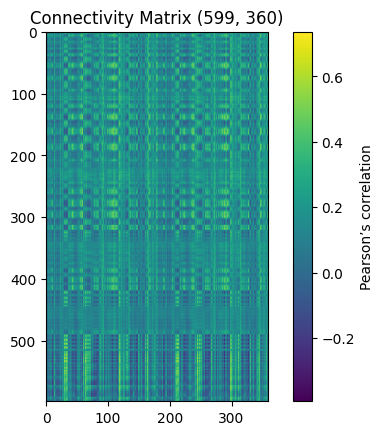

In [6]:
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(corr_avg[:,:-19])
ax.set_title('Connectivity Matrix {}'.format(corr_avg[:,:-19].shape))
cbar = plt.colorbar(im)
cbar.set_label("Pearson’s correlation")
plt.show()

In [7]:
# Average correlation matrix
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

In [8]:
# remove the extra subcortical regions 
corr_avgFC = corr_avg[:,:-19]

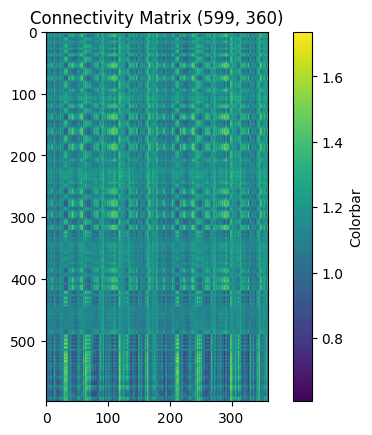

In [9]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(corr_avgFC)
ax.set_title('Connectivity Matrix {}'.format(corr_avgFC.shape))
cbar = plt.colorbar(im)
cbar.set_label("Colorbar")
plt.show()

In [9]:
pd.DataFrame(corr_avgFC).to_csv(results_path + f'Func_corr-avgFC.csv', index=False)

### Calculate Gradient

In [11]:
sm = compute_affinity(corr_avgFC,kernel='normalized_angle')

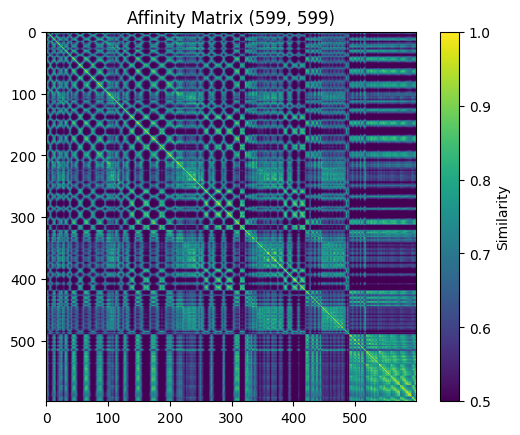

In [12]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(sm)
ax.set_title('Affinity Matrix {}'.format(sm.shape))
cbar = plt.colorbar(im)
cbar.set_label("Similarity")
plt.show()

In [12]:
n_components=100 # specify gradinet components here

In [13]:
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=n_components, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr_avgFC))

GradientMaps(kernel='normalized_angle', n_components=100, random_state=0)


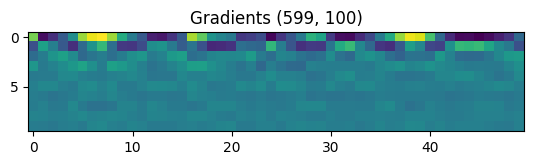

In [12]:
# Plot this gradients (up to 10 component and 50 BF voxel)
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(gm.gradients_[:50, :10].T)
ax.set_title('Gradients {}'.format(gm.gradients_.shape))
plt.show()

In [13]:
# save the gradient
pd.DataFrame(gm.gradients_).to_csv(results_path + f'Func_gradients-{n_components}_seed-BASF_1p6mm.csv', index=False)

In [15]:
# save the (up to 4 components) as nifti files
# get seed data
seed_file = (data_path + 'seed_1p6mm.nii.gz')
seed = nib.load(seed_file)
seed_vol = seed.get_fdata()

for gradi in range(n_components):

    grad_vol = np.zeros(seed_vol.shape)
    grad_vol[indices[:,0],indices[:,1],indices[:,2]] = gm.gradients_[:,gradi] 

    grad_nib = nib.Nifti1Image(grad_vol,affine=seed.affine,header=seed.header)
    grad_nib.to_filename(results_path + f'Func_gradient_{gradi+1}.nii.gz')

### Gradient 1 specific (for Supplemetal Figs)

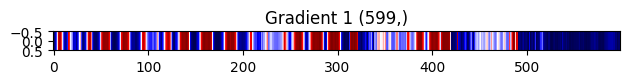

In [15]:
# Plot this gradient 1
f, ax = plt.subplots(1,1,dpi=100)
G1 = gm.gradients_[:,0]
G1.shape

ax.imshow(G1.reshape([599,1]).T, cmap='seismic', aspect=20)
ax.set_title('Gradient 1 {}'.format(G1.shape))
plt.tight_layout()
plt.show()

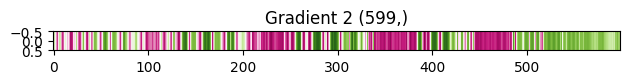

In [18]:
# Plot this gradient 1
f, ax = plt.subplots(1,1,dpi=100)
G = gm.gradients_[:,1]
G.shape

ax.imshow(G.reshape([599,1]).T, cmap='PiYG', aspect=20)
ax.set_title('Gradient 2 {}'.format(G.shape))
plt.tight_layout()
plt.show()

In [16]:
G1m = np.diag(G1.reshape([599]))
G1m.shape

(599, 599)

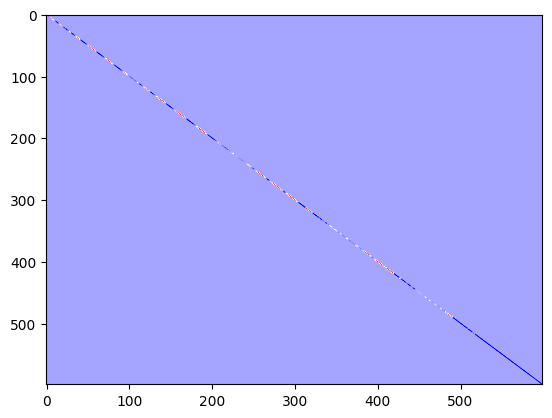

In [17]:
import matplotlib.pyplot as plt
plt.imshow(G1m, cmap='seismic', aspect='auto')

### Calculate Gradient Variance 

/tmp/ipykernel_1393989/192309415.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


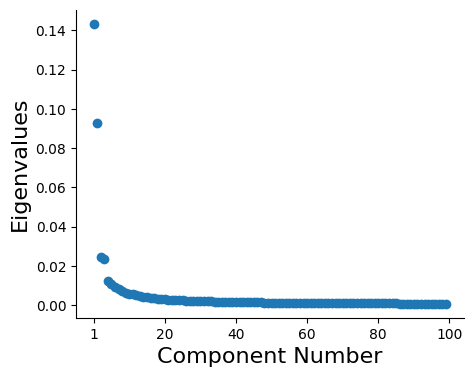

In [18]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_)
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Eigenvalues', fontsize=16)
plt.savefig(fig_path + f'Func_Gradient_eiganvalue_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1393989/601751770.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


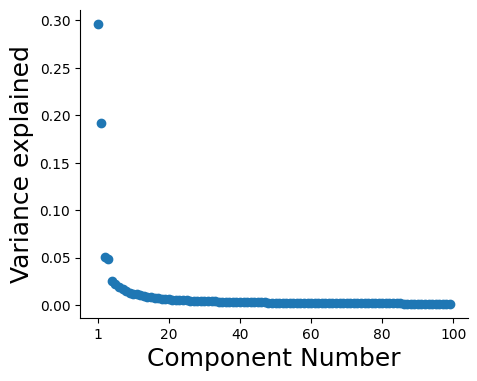

In [19]:
variance = gm.lambdas_ / np.sum(gm.lambdas_)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(variance.size), variance)
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=18)
ax.set_ylabel('Variance explained', fontsize=18)
plt.savefig(fig_path + f'Func_Gradient_variance_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
pd.DataFrame(variance).to_csv(results_path + f'Func_gradients_variance_gm-{n_components}.csv', index=False)

/tmp/ipykernel_1393989/662847605.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


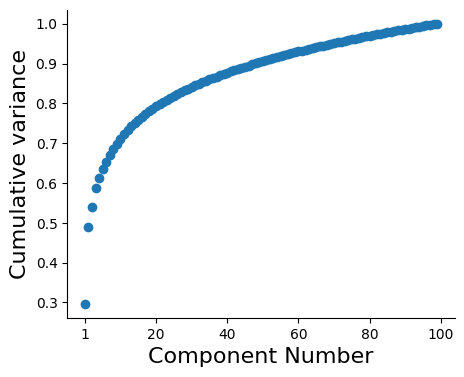

In [21]:
cum_var = np.cumsum(gm.lambdas_) / np.sum(gm.lambdas_)
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(cum_var.size), cum_var)
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Cumulative variance', fontsize=16)
plt.savefig(fig_path + f'Func_Gradient_cumulative-variance_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualize Gradients

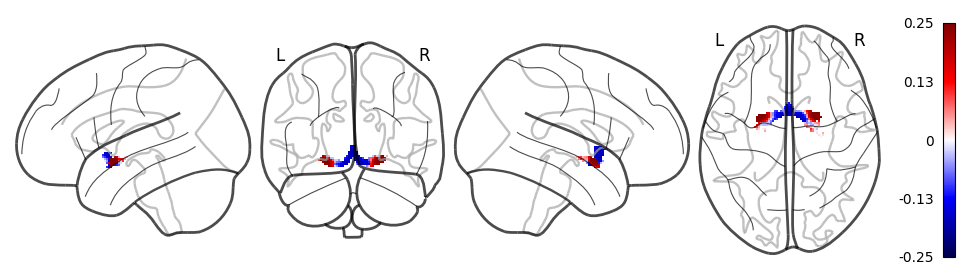

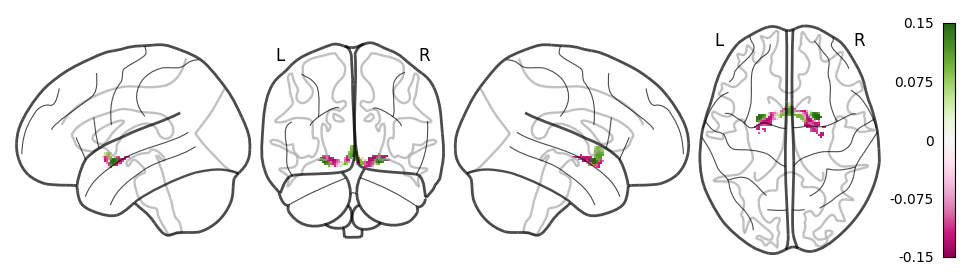

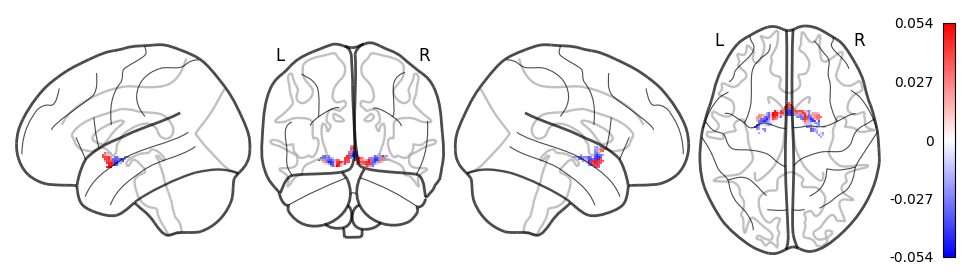

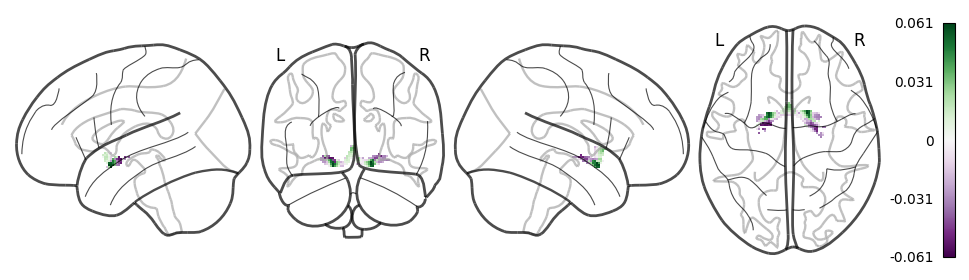

In [22]:
colors = ['seismic','PiYG','bwr','PRGn']

for gradi in range(4):
    grad_nib = nib.load(results_path + f'Func_gradient_{gradi+1}.nii.gz')
    color = matplotlib.cm.get_cmap(colors[gradi])
    plot_glass_brain(grad_nib, colorbar=True, display_mode='lyrz', plot_abs=False, cmap=color)
    plt.savefig(fig_path + f'Func_Gradient_{gradi+1}.png',dpi=300)

#### scatter plot visualize

In [26]:
fname = (results_path + 'Func_gradient_{0}.nii.gz')

In [27]:
G_idx = {}
G_values = {}
for g in range(1,5):
    G_nii = nib.load(fname.format(g)).get_fdata()
    G_idx[g] = np.argwhere(G_nii)
    G_values[g] = G_nii[G_idx[g][:,0], G_idx[g][:,1], G_idx[g][:,2]].flatten()

/tmp/ipykernel_1393989/917232424.py:7: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=10


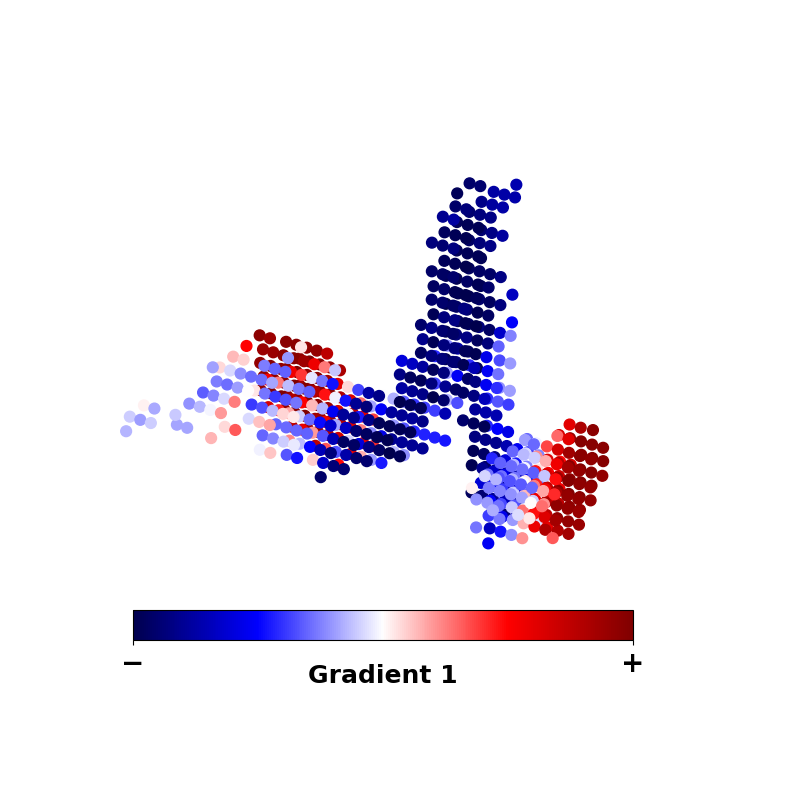

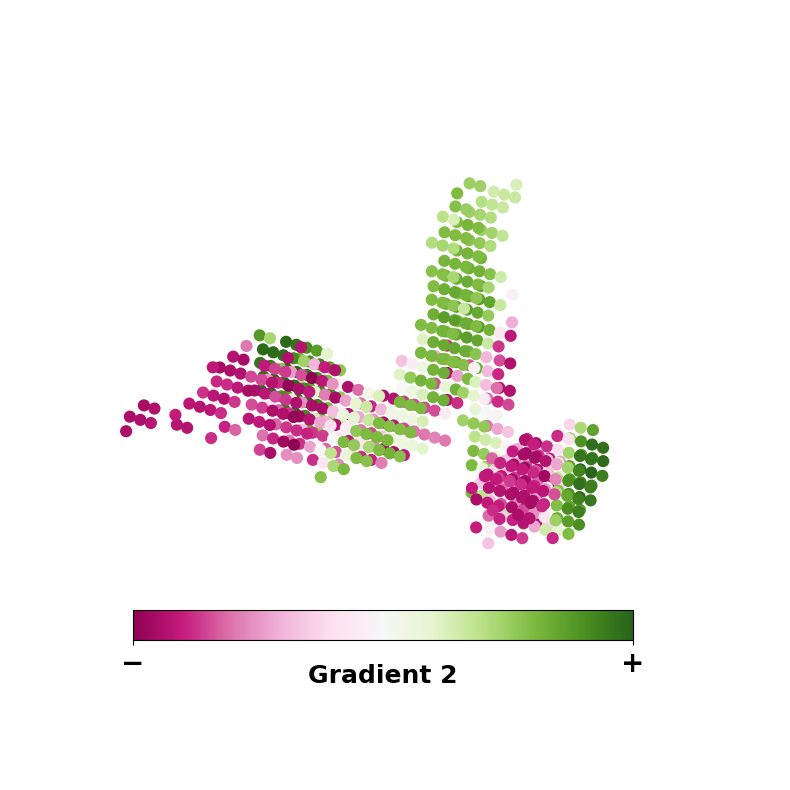

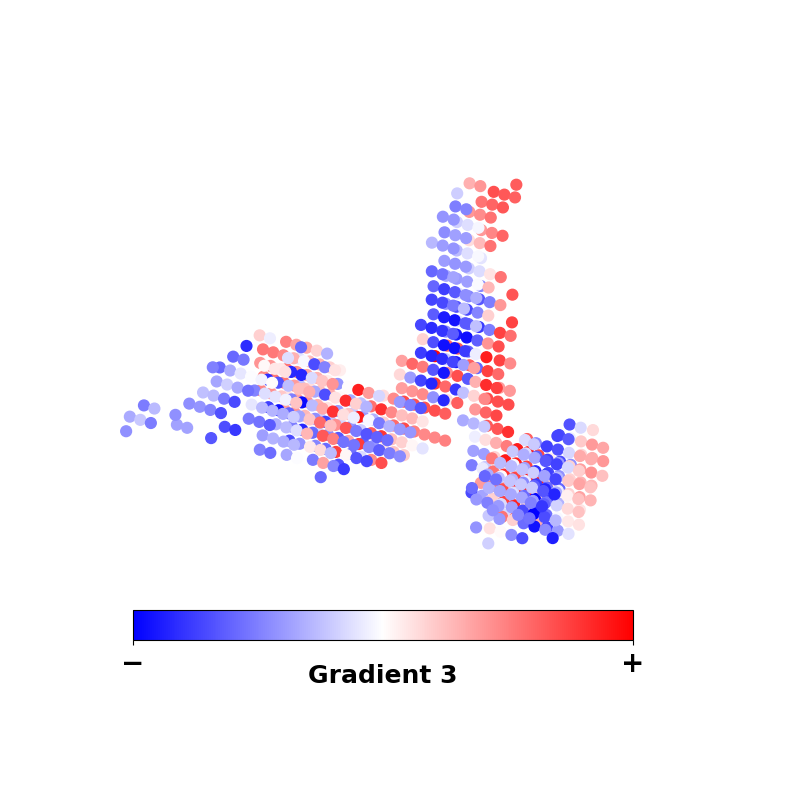

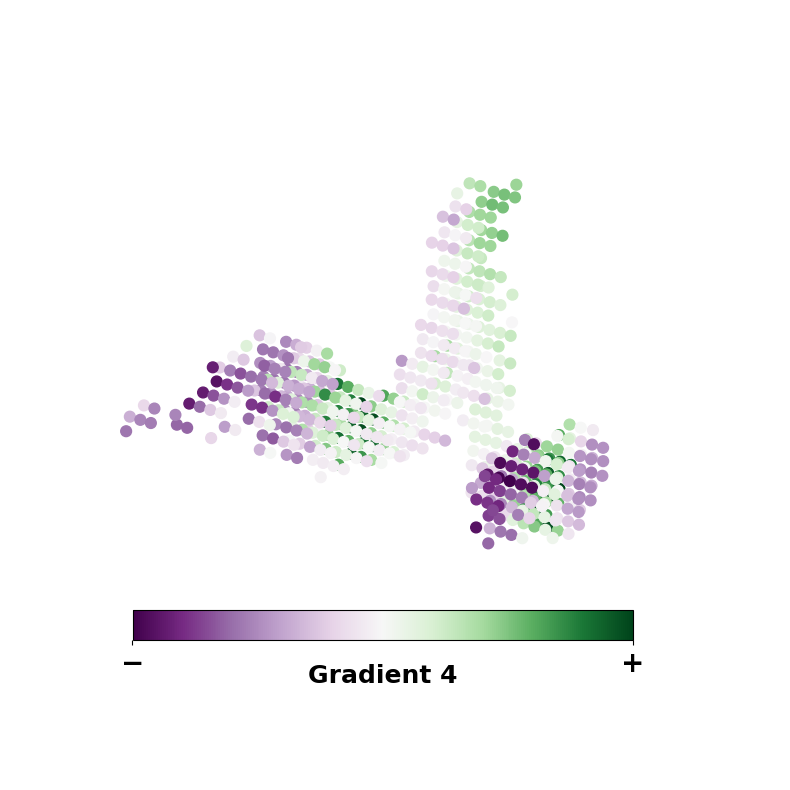

In [29]:
colors = ['seismic','seismic','PiYG','bwr','PRGn','coolwarm',]

for g in range(1,5):
    # Plot using 3D scatter plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.dist=10
    ax.set_axis_off()
    
    ax.scatter(
        G_idx[g][:,0],
        G_idx[g][:,1],
        G_idx[g][:,2],
        s=60, alpha=1,
        cmap=colors[g], vmin=G_values[g].min(), vmax=G_values[g].max(), 
        c=G_values[g]
    )
    # Add legend    
    norm = matplotlib.colors.Normalize(G_values[g].min(), G_values[g].max())
    cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
    cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=colors[g]), 
                      ticks=[G_values[g].min(), G_values[g].max()], cax=cb_ax, orientation='horizontal')
    cb.set_label(f"Gradient {g}", fontsize=18, labelpad=-10, weight=600)
    cb.ax.set_xticklabels(['−','+'], fontsize=20, weight=600) 
    
    plt.savefig(fig_path + f'Func_Gradient_{g}_scatterplot.png', dpi=300, bbox_inches='tight')
    plt.show()

### BF-gradient weighted corical projection

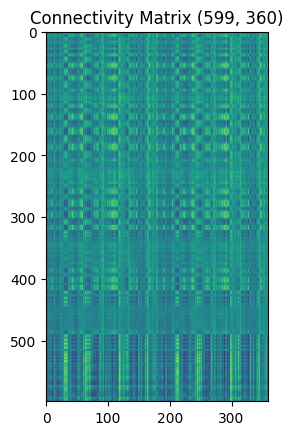

In [30]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_avgFC)
ax.set_title('Connectivity Matrix {}'.format(corr_avgFC.shape))
plt.show()

In [31]:
G_Ctx = {}
for g in range(4):
    G_Ctx[g] = np.zeros(corr_avgFC.shape)
    for i in range(len(gm.gradients_[:,g])):
        G_Ctx[g][i,:] = corr_avgFC[i,:]*gm.gradients_[i,g]

In [32]:
np.savez(results_path + 'Func_Gradient-weighted_CorticalConnectivity.npz', G1_Ctx=G_Ctx[0], G2_Ctx=G_Ctx[1], G3_Ctx=G_Ctx[2], G4_Ctx=G_Ctx[3])

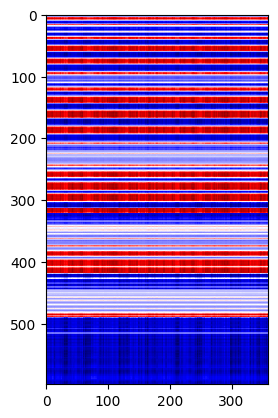

In [33]:
G1_Ctx=G_Ctx[0]
# Plot the G1 weighthed connectivity matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(G1_Ctx, cmap='seismic')
# ax.set_title('G1-weighted Connectivity Matrix {}'.format(G1_Ctx.shape))
#plt.savefig(fig_path + f'Func_Schaefer_G1-weighted_Connectivity_Matrix.png')
plt.show()

In [35]:
Gfc = {}
for g in range(4):
    Gfc[g] = np.nanmean(G_Ctx[g], axis=0).reshape([360,1])

In [36]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [37]:
G_cortex = {}
for g in range(4):
    G_cortex[g] = map_to_labels(Gfc[g].reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [38]:
colors = ['seismic','PiYG','bwr','PRGn']

In [39]:
for gradi in range(4):
    plot_hemispheres(surf_lh, surf_rh, array_name=[G_cortex[gradi]], size=(400, 400), layout_style='grid', 
                     label_text=[f'Gradient-{gradi+1}'], cmap=[colors[gradi],colors[gradi]], color_bar=False, color_range='sym', zoom=1.2,
                     embed_nb=True, screenshot=True, filename=fig_path+f'Func_Grad-{gradi+1}_weighted_cortex.png' )

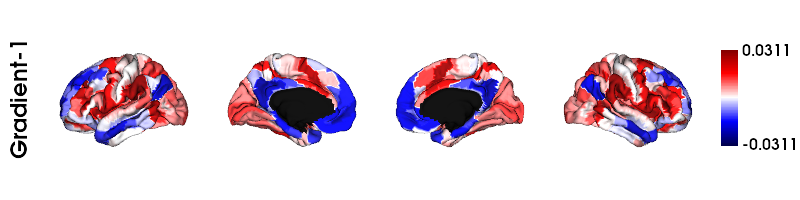

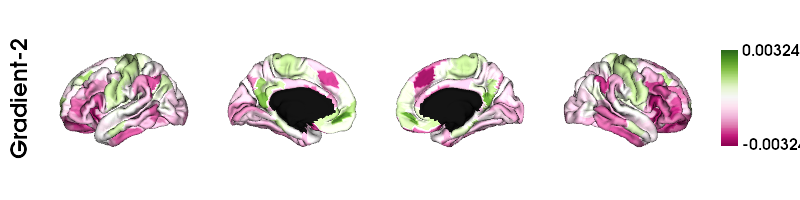

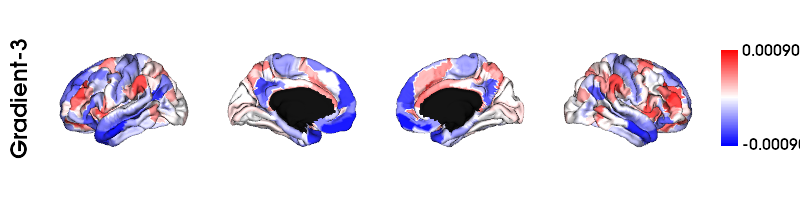

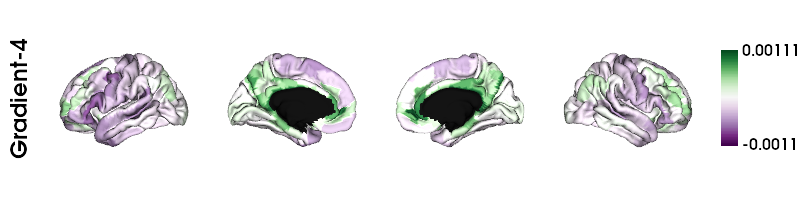

In [40]:
for gradi in range(4):
    fig = plot_hemispheres(surf_lh, surf_rh, array_name=[G_cortex[gradi]],label_text=[f'Gradient-{gradi+1}'],
                           size=(800, 200), cmap=[colors[gradi]], color_range='sym', color_bar=True, embed_nb=True)
    display(fig)

In [41]:
# Save the cortical projection as gii files

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Func_Gradient-'+str(g+1)+'_weighted_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Func_Gradient-'+str(g+1)+'_weighted_R_fsa-10k.gii')

### Gradient x Atlas subregion

In [18]:
subBF_nib = nib.load(data_path+'BF_masked_fullB_1p6mm.dseg.nii.gz')
subBF_vol = subBF_nib.get_fdata()

#### BF atlas color ref

In [19]:
bf_idx = np.argwhere(subBF_vol)
bf_values = subBF_vol[bf_idx[:,0], bf_idx[:,1], bf_idx[:,2]].flatten()

/tmp/ipykernel_5792/3685974509.py:6: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=10


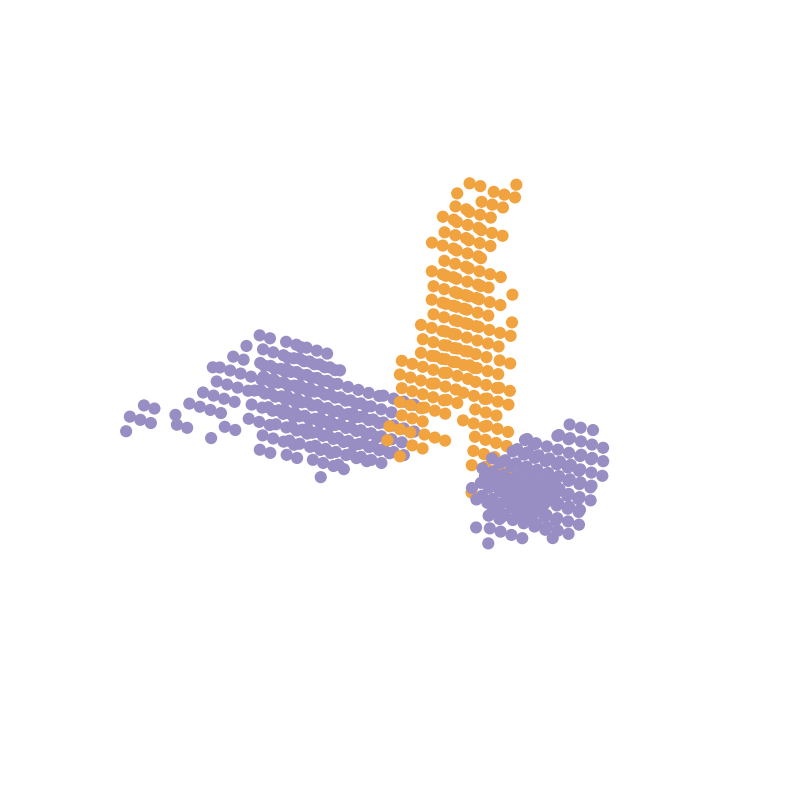

In [23]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(['#f1a340', '#998ec3'])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.dist=10
ax.set_axis_off()
    
ax.scatter(
    bf_idx[:,0],
    bf_idx[:,1],
    bf_idx[:,2],
    s=60, alpha=1,
    cmap=colors,
    c=bf_values
)

#plt.savefig(fig_path+f'BF-atlas_color-ref.png', dpi=300, bbox_inches='tight')
plt.show()

#### get gradient data and plot distribution across the atlas

In [16]:
grad_1_nib = nib.load(results_path +'Func_gradient_1.nii.gz')
grad_1_vol = grad_1_nib.get_fdata()
grad_2_nib = nib.load(results_path +'Func_gradient_2.nii.gz')
grad_2_vol = grad_1_nib.get_fdata()

In [20]:
df = pd.DataFrame(
    dict(
        labels=subBF_vol[subBF_vol!=0].flatten(),
        funcG1=grad_1_vol[subBF_vol!=0].flatten(),
        funcG2=grad_2_vol[subBF_vol!=0].flatten()
    )
)

In [47]:
pd.DataFrame(df).to_csv(results_path + f'Func_grad-atlas2labels.csv', index=False)

In [26]:
labels = ['Ch123', 'Ch4a/Ch4p']

<function matplotlib.pyplot.show(close=None, block=None)>

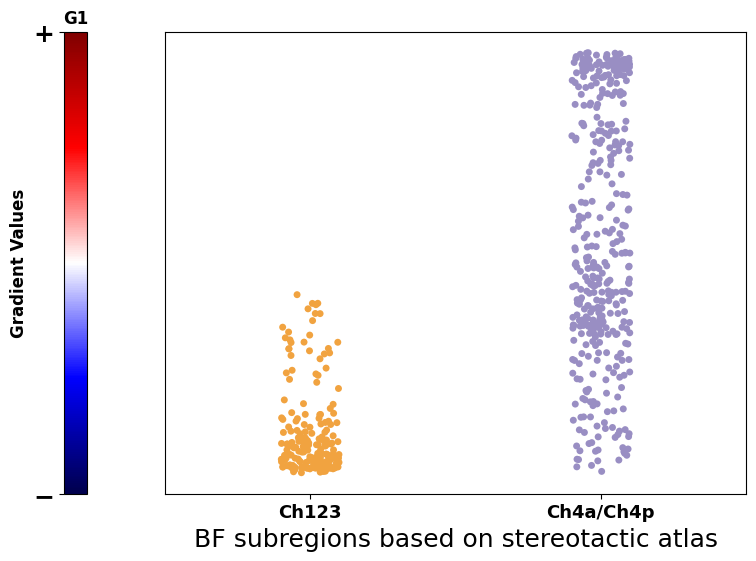

In [28]:
# strip plot
#colors = ListedColormap(['#f1a340', '#998ec3'])
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.stripplot(data=df, x="labels", y="funcG1", palette=['#f1a340', '#998ec3'])
ax.set_xticklabels(labels, size=18, weight=600)
plt.xlabel('BF subregions based on stereotactic atlas', size=18)
plt.ylabel("")
#plt.title('Functional Gradient 1', size=14, weight=900)
plt.xticks(size=13)
plt.yticks([])

cmap = plt.get_cmap("seismic")
norm = plt.Normalize(df['funcG1'].min(), df['funcG1'].max())
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, location='left', ticks=[df['funcG1'].min(), df['funcG1'].max()])
cbar.ax.set_yticklabels(['−','+'], fontsize=18, weight=600)
cbar.ax.set_ylabel("Gradient Values", fontsize=12, weight=600)
cbar.ax.set_title("G1", fontsize=12, weight=900)

plt.savefig(fig_path+f'Func_HCPMMP_gradient1-atlas-2label_stripplot.png', dpi=300, bbox_inches='tight')
plt.show

### stats

In [50]:
df = pd.read_csv(results_path + f'Func_grad-atlas2labels.csv')
df[df.labels == 1].head(5)

,labels,funcG1,funcG2
224,1.0,-0.172200,-0.172200
226,1.0,-0.133215,-0.133215
227,1.0,-0.125651,-0.125651
228,1.0,-0.090703,-0.090703
231,1.0,-0.171859,-0.171859


In [51]:
ch123 = df.loc[df.labels == 1, 'funcG1'].values
ch44p = df.loc[df.labels == 2, 'funcG1'].values

#### Simple t-test

In [52]:
import pingouin as pg
from pingouin import ttest

ttest_emp = ttest(ch123,ch44p)

In [53]:
ttest_emp

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-28.25535,561.038094,two-sided,6.655016e-110,"[-0.22, -0.19]",1.859985,1.321e+108,1.0


#### permutation test prep

In [54]:
# Load seed mask
mask = nib.load(data_path+'seed_1p6mm.nii.gz')
mask = mask.get_fdata()
ind  = np.argwhere(mask)

In [55]:
# Load BASF atlas
atlas     = nib.load(data_path+'BF_masked_fullB_1p6mm.dseg.nii.gz')
atlas     = atlas.get_fdata()
atlas     = atlas[atlas!=0]

In [56]:
# load data and atlas
df = pd.read_csv(results_path + f'Func_grad-atlas2labels.csv')

In [57]:
funcG1 = df['funcG1'].values

In [58]:
from sklearn.preprocessing import MinMaxScaler
# min-max scale, for compatability with non-resampled surrogate maps
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(funcG1[:,np.newaxis])

/tmp/ipykernel_1393989/849106545.py:6: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=6
/tmp/ipykernel_1393989/849106545.py:19: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


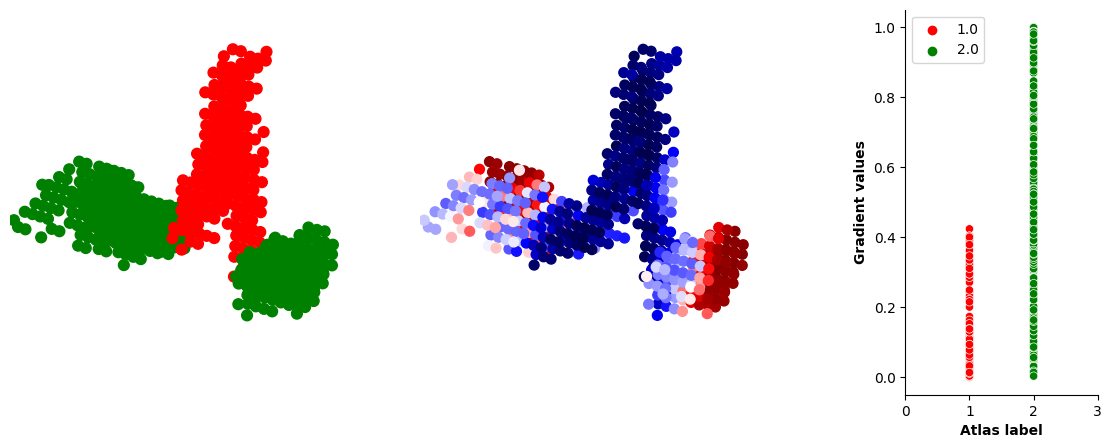

In [59]:
# Plot data
colors = ListedColormap(['red', 'green'])

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131, projection='3d')
ax.dist=6
ax.set_axis_off()
    
ax.scatter(
    ind[:,0],
    ind[:,1],
    ind[:,2],
    s=60, alpha=1,
    cmap=colors,
    c=atlas
)

ax1 = fig.add_subplot(132, projection='3d')
ax1.dist=6
ax1.set_axis_off()

ax1.scatter(
    ind[:,0],
    ind[:,1],
    ind[:,2],
    s=50, alpha=1,
    cmap='seismic',
    c=data_scaled[:,0]
)

ax2 = fig.add_subplot(133, box_aspect=2)
sns.scatterplot(x=atlas, y=data_scaled[:,0], hue=atlas, palette={1: 'red', 2: 'green'}, ax=ax2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Gradient values', weight='bold')
ax2.set_xlabel('Atlas label', weight='bold')
ax2.set_xlim((0,3))

plt.show()

#### Surrogate Map

In [60]:
# Calculate distance matrix for BASF voxels
dist = cdist(ind, ind)

In [61]:
# compute variograms
vg = SurrogateMaps(
    resample=False,
    pv=60,
    random_state=1234
).fit(dist)

In [62]:
# Calculate empirical variogram
emp_var = vg.compute_variogram(data_scaled[:,0])
emp_var, u0 = vg.smooth_variogram(emp_var, return_h=True)

In [63]:
# Then use the fitted SurrogateMaps function to generate surrogate map
nsurr = 1000
surr = vg.randomize(data_scaled[:,0], n_rep=nsurr)

In [64]:
# Compute surrogate map variograms
surr_var = np.empty((nsurr, len(emp_var)))
for i in range(nsurr):
    tmp = vg.compute_variogram(np.array(surr[i,:]))
    surr_var[i] = vg.smooth_variogram(tmp)

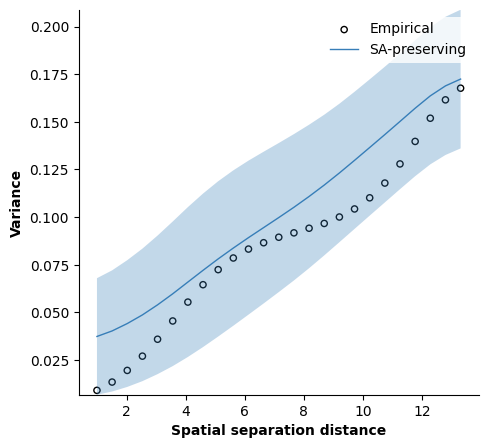

In [65]:
# # Create plot for inspecting fit of surrogate models
# Plot empirical variogram
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.77])
ax.autoscale(axis='y', tight=True)

ax.scatter(u0, emp_var, s=20, facecolor='none', edgecolor='k',
           marker='o', lw=1, label='Empirical')

# Plot surrogate maps' variograms
mu = surr_var.mean(axis=0)
sigma = surr_var.std(axis=0)
ax.fill_between(u0, mu-sigma, mu+sigma, facecolor='#377eb8',
                edgecolor='none', alpha=0.3)
ax.plot(u0, mu, color='#377eb8', label='SA-preserving', lw=1)

# Make plot nice
leg = ax.legend(loc=0)
leg.get_frame().set_linewidth(0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Spatial separation distance", weight='bold')
ax.set_ylabel("Variance", weight='bold')

plt.show()

/tmp/ipykernel_1393989/1985664439.py:4: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=6


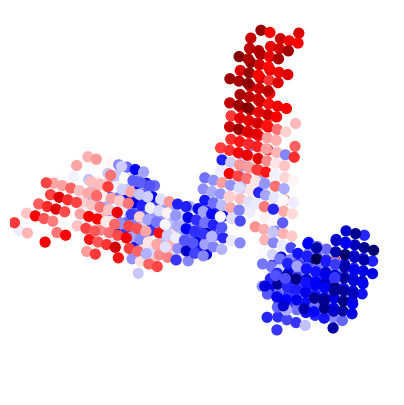

In [66]:
# PLot surrogate map example
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.dist=6
ax.set_axis_off()

ax.scatter(
    ind[:,0],
    ind[:,1],
    ind[:,2],
    s=50, alpha=1,
    cmap='seismic',
    c=surr[0,:]
)

#### Variability stat (Ch123-Ch44p)

In [67]:
# Calculate variability for empirical data
x1 = data_scaled[atlas==1]
x2 = data_scaled[atlas==2]

# Standard deviation
std1 = np.std(x1)
std2 = np.std(x2)
emp_std_diff = std1-std2

# Variance
var1 = np.var(x1)
var2 = np.var(x2)
emp_var_diff = var1-var2

# Coefficient of variation
cov = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
cov1 = cov(x1)
cov2 = cov(x2)
emp_cov_diff = cov1-cov2

In [68]:
print(emp_var_diff)
print(emp_cov_diff)

-0.07759709090266784
56.55763303881027


In [69]:
# Calculate surrogate variability
surr_std_diff = np.empty((nsurr, 1))
surr_var_diff = np.empty((nsurr, 1))
surr_cov_diff = np.empty((nsurr, 1))

for i in range(nsurr):
    x1 = surr[i,atlas==1]
    x2 = surr[i,atlas==2]
    
    # Standard deviation
    std1 = np.std(x1)
    std2 = np.std(x2)
    surr_std_diff[i] = std1-std2
    
    # Variance
    var1 = np.var(x1)
    var2 = np.var(x2)
    surr_var_diff[i] = var1-var2
    
    # Coefficient of variation
    cov = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
    cov1 = cov(x1)
    cov2 = cov(x2)
    surr_cov_diff[i] = cov1-cov2

Pvalue = 0.359


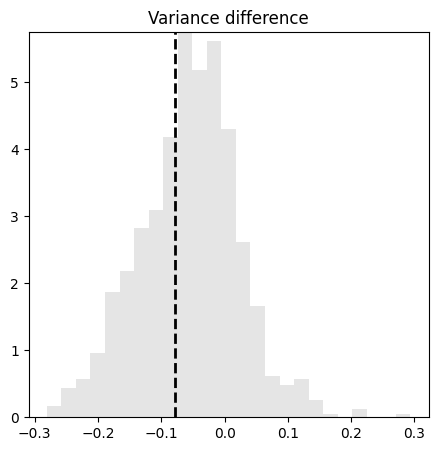

In [70]:
# Plot 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.77])
ax.autoscale(axis='y', tight=True)

ax.hist(surr_var_diff, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
ax.axvline(emp_var_diff, lw=2, ls='--', color='k')
ax.set_title('Variance difference')

pvalue = 1-(np.sum(surr_var_diff>emp_var_diff)/nsurr)
print(f'Pvalue = {pvalue}')

Pvalue = 1.0


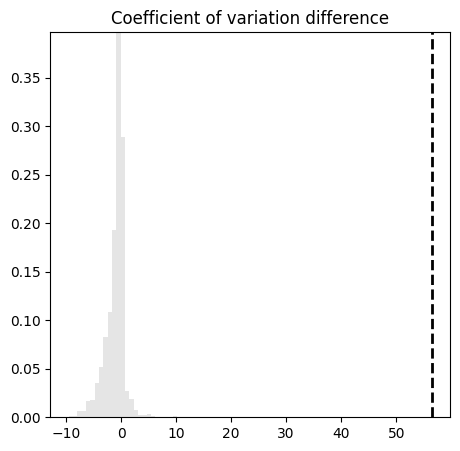

In [71]:
# Plot 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.77])
ax.autoscale(axis='y', tight=True)

ax.hist(surr_cov_diff, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
ax.axvline(emp_cov_diff, lw=2, ls='--', color='k')
ax.set_title('Coefficient of variation difference')

pvalue = 1-(np.sum(surr_cov_diff>emp_cov_diff)/nsurr)
print(f'Pvalue = {pvalue}')

Pvalue = 0.15600000000000003


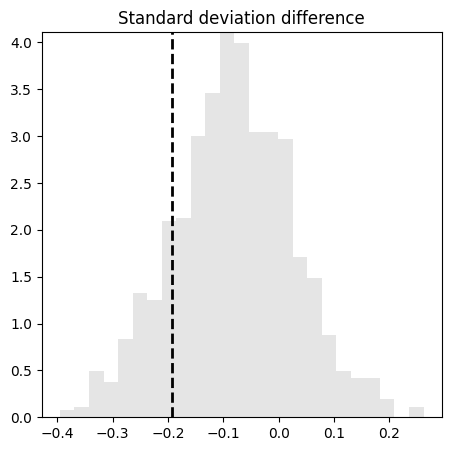

In [72]:
# Plot 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.77])
ax.autoscale(axis='y', tight=True)

ax.hist(surr_std_diff, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
ax.axvline(emp_std_diff, lw=2, ls='--', color='k')
ax.set_title('Standard deviation difference')

pvalue = 1-(np.sum(surr_std_diff>emp_std_diff)/nsurr)
print(f'Pvalue = {pvalue}')

In [73]:
print(surr_var_diff.mean())
print(surr_cov_diff.mean())

-0.055732707961498235
-1.0320434203892133


#### Variability stat (Ch44p-Ch123)

In [74]:
# Calculate variability for empirical data
x2 = data_scaled[atlas==1]
x1 = data_scaled[atlas==2]

# Standard deviation
std1 = np.std(x1)
std2 = np.std(x2)
emp_std_diff = std1-std2

# Variance
var1 = np.var(x1)
var2 = np.var(x2)
emp_var_diff = var1-var2

# Coefficient of variation
cov = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
cov1 = cov(x1)
cov2 = cov(x2)
emp_cov_diff = cov1-cov2

In [75]:
print(emp_var_diff)
print(emp_cov_diff)

0.07759709090266784
-56.55763303881027


In [76]:
# Calculate surrogate variability
surr_std_diff = np.empty((nsurr, 1))
surr_var_diff = np.empty((nsurr, 1))
surr_cov_diff = np.empty((nsurr, 1))

for i in range(nsurr):
    x2 = surr[i,atlas==1]
    x1 = surr[i,atlas==2]
    
    # Standard deviation
    std1 = np.std(x1)
    std2 = np.std(x2)
    surr_std_diff[i] = std1-std2
    
    # Variance
    var1 = np.var(x1)
    var2 = np.var(x2)
    surr_var_diff[i] = var1-var2
    
    # Coefficient of variation
    cov = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
    cov1 = cov(x1)
    cov2 = cov(x2)
    surr_cov_diff[i] = cov1-cov2

Pvalue = 0.641


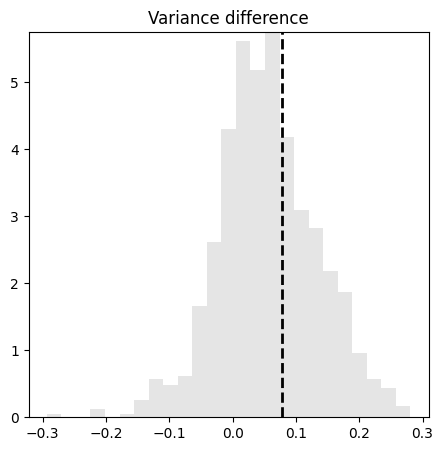

In [77]:
# Plot 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.77])
ax.autoscale(axis='y', tight=True)

ax.hist(surr_var_diff, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
ax.axvline(emp_var_diff, lw=2, ls='--', color='k')
ax.set_title('Variance difference')

pvalue = 1-(np.sum(surr_var_diff>emp_var_diff)/nsurr)
print(f'Pvalue = {pvalue}')

Pvalue = 0.0


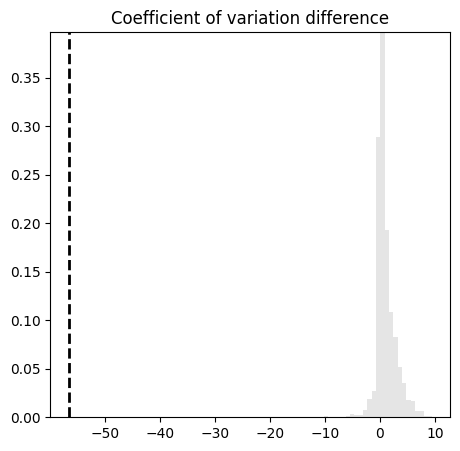

In [78]:
# Plot 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.77])
ax.autoscale(axis='y', tight=True)

ax.hist(surr_cov_diff, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
ax.axvline(emp_cov_diff, lw=2, ls='--', color='k')
ax.set_title('Coefficient of variation difference')

pvalue = 1-(np.sum(surr_cov_diff>emp_cov_diff)/nsurr)
print(f'Pvalue = {pvalue}')

Pvalue = 0.844


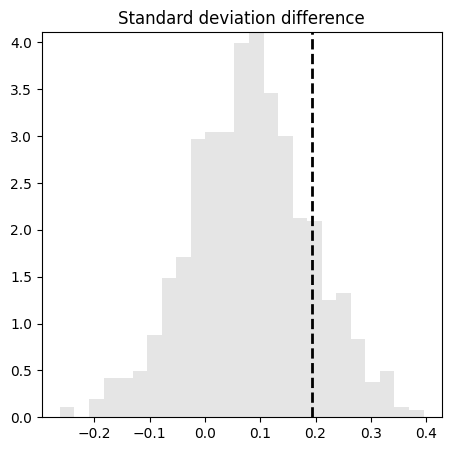

In [79]:
# Plot 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.77])
ax.autoscale(axis='y', tight=True)

ax.hist(surr_std_diff, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
ax.axvline(emp_std_diff, lw=2, ls='--', color='k')
ax.set_title('Standard deviation difference')

pvalue = 1-(np.sum(surr_std_diff>emp_std_diff)/nsurr)
print(f'Pvalue = {pvalue}')

#### Mean difference

In [80]:
# Calculate mean diff for empirical data
x1 = data_scaled[atlas==1]
x2 = data_scaled[atlas==2]

# Mean 
mean1 = np.mean(x1)
mean2 = np.mean(x2)
emp_mean_diff = mean1-mean2

In [81]:
print(emp_mean_diff)

-0.4689570969244998


In [82]:
# Calculate surrogate mean diff
surr_mean_diff = np.empty((nsurr, 1))

for i in range(nsurr):
    x1 = surr[i,atlas==1]
    x2 = surr[i,atlas==2]
    
    # Standard deviation
    mean1 = np.mean(x1)
    mean2 = np.mean(x2)
    surr_mean_diff[i] = mean1-mean2

Pvalue = 0.0030000000000000027


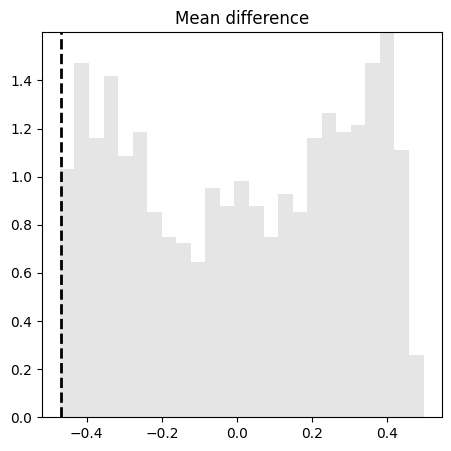

In [83]:
# Plot 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.77])
ax.autoscale(axis='y', tight=True)

ax.hist(surr_mean_diff, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
ax.axvline(emp_mean_diff, lw=2, ls='--', color='k')
ax.set_title('Mean difference')

pvalue = 1-(np.sum(surr_mean_diff>emp_mean_diff)/nsurr)
print(f'Pvalue = {pvalue}')